In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import numpy as np

import vpfits

# Mock Spectrum

This randomly generated mock spectrum has multiple regions of absorption features that we want to fit.

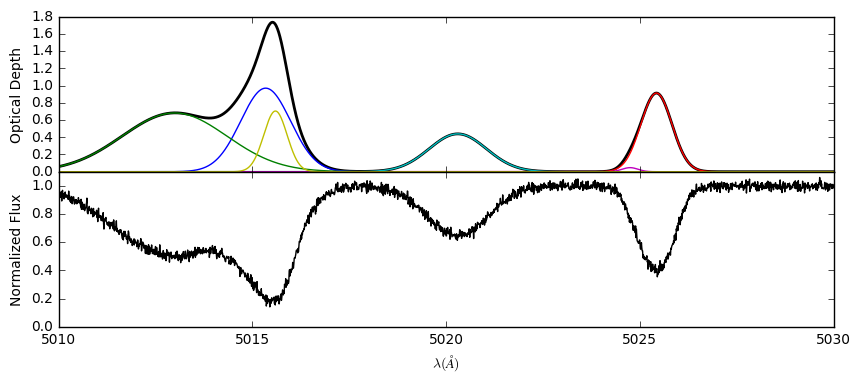

In [38]:
n = 6
clouds, wavelength_array = vpfits.mock_absorption(n=n, plot=True)

In [39]:
vpfit = vpfits.VPfit()
onesigmaerror = 0.02
noise = np.random.normal(0.0, onesigmaerror, len(wavelength_array))
flux_array = vpfit.Absorption(sum(clouds['tau'])) + noise

# Region Detection

Regions are detected based on a detection threshold of 4 sigma. The number of pixels needed below the threshold to divide regions is set with `buffer`, and the minimum width of a region is set with `min_region_width` in pixels.

The `compute_detection_regions` function outputs a numpy array of the start and end wavelengths of each region.

In [40]:
buffer = 3
min_region_width = 5
regions = vpfit.compute_detection_regions(wavelength_array, flux_array, noise, 
                                          buffer=buffer, min_region_width=min_region_width)
print(regions)

[[ 5010.01  5017.68]
 [ 5017.96  5022.2 ]
 [ 5022.28  5022.38]
 [ 5024.1   5026.6 ]]


Note that a 10-pixel region of noise was selected as a detection region; this parameter needs to be properly tuned to avoid false regions.

In [45]:
region_arrays = []
region_pixels = []
for region in regions:
    start = np.where(wavelength_array==region[0])[0][0]
    end = np.where(wavelength_array==region[1])[0][0]
    region_pixels.append([start, end])
    region_arrays.append([wavelength_array[start:end], flux_array[start:end]])

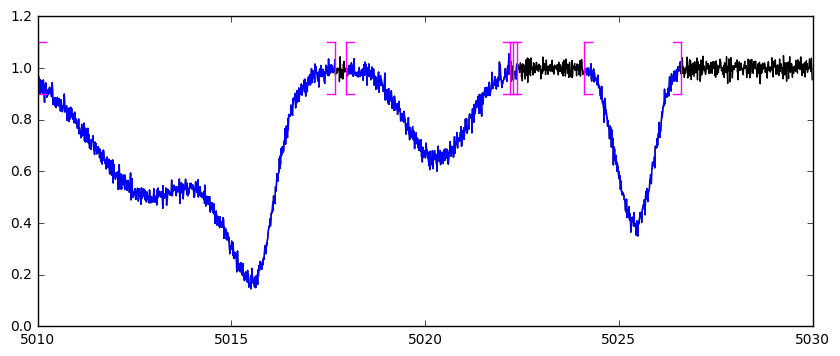

In [59]:
plt.plot(wavelength_array, flux_array, c='black')

for arr in region_arrays:
    plt.plot(arr[0], arr[1], color='blue')

def plot_bracket(x, dir):
    height = .2
    arm_length = 0.2
    plt.plot((x, x), (1-height/2, 1+height/2), color='magenta')
    if dir=='left':
        xarm = x+arm_length
    if dir=='right':
        xarm = x-arm_length
    plt.plot((x, xarm), (1-height/2, 1-height/2), color='magenta')
    plt.plot((x, xarm), (1+height/2, 1+height/2), color='magenta')
  
for (start, end) in region_pixels:
    plot_bracket(wavelength_array[start], 'left')
    plot_bracket(wavelength_array[end], 'right')
    
plt.show()

# Fitting Regions

Now we can loop over each region and run the main fitting routine separately on each region, finding the optimal number of profiles for each.

 [-----------------100%-----------------] 10000 of 10000 complete in 5.5 sec
Took: 0:00:05.471095  to finish.
n:  1
 [-----------------100%-----------------] 10000 of 10000 complete in 10.9 sec
Took: 0:00:10.908916  to finish.
-930.537889028
-2768.84109438
0.336074862121
n:  2
 [-----------------100%-----------------] 10000 of 10000 complete in 15.4 sec
Took: 0:00:15.388276  to finish.
-2768.84109438
-3846.78610647
0.719780361513
n:  3
 [-----------------100%-----------------] 10000 of 10000 complete in 20.3 sec
Took: 0:00:20.275014  to finish.
-3846.78610647
-3853.30279414
0.998308804677


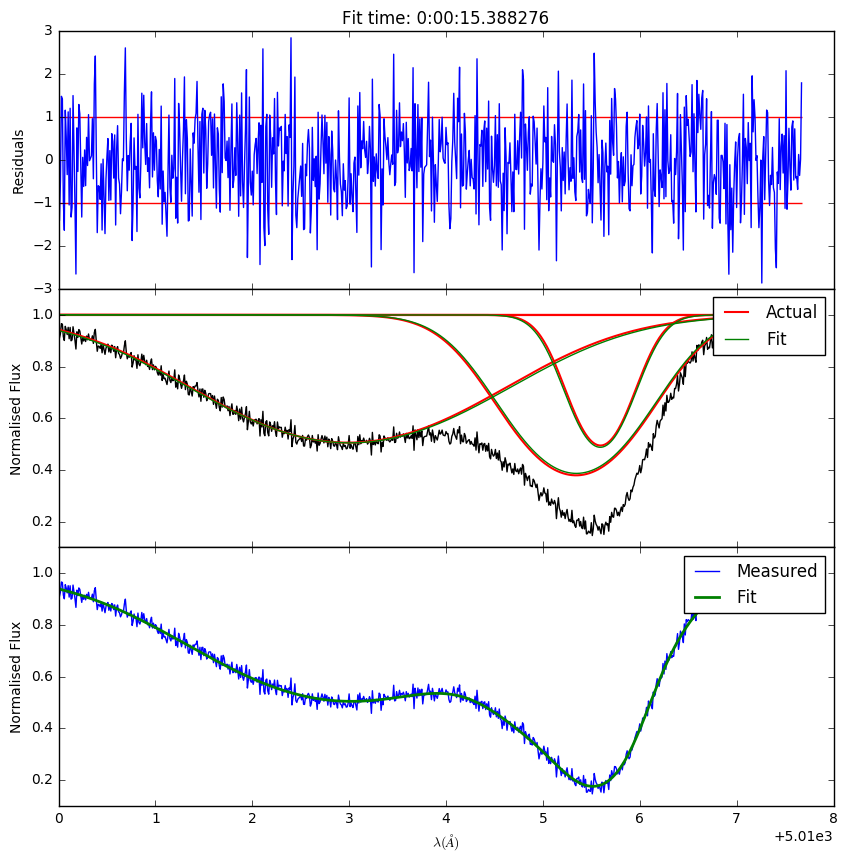

 [-----------------100%-----------------] 10000 of 10000 complete in 5.3 sec
Took: 0:00:05.348579  to finish.
n:  1
 [-----------------100%-----------------] 10000 of 10000 complete in 10.1 sec
Took: 0:00:10.056221  to finish.
-2059.66858403
-2063.01630846
0.998377267105


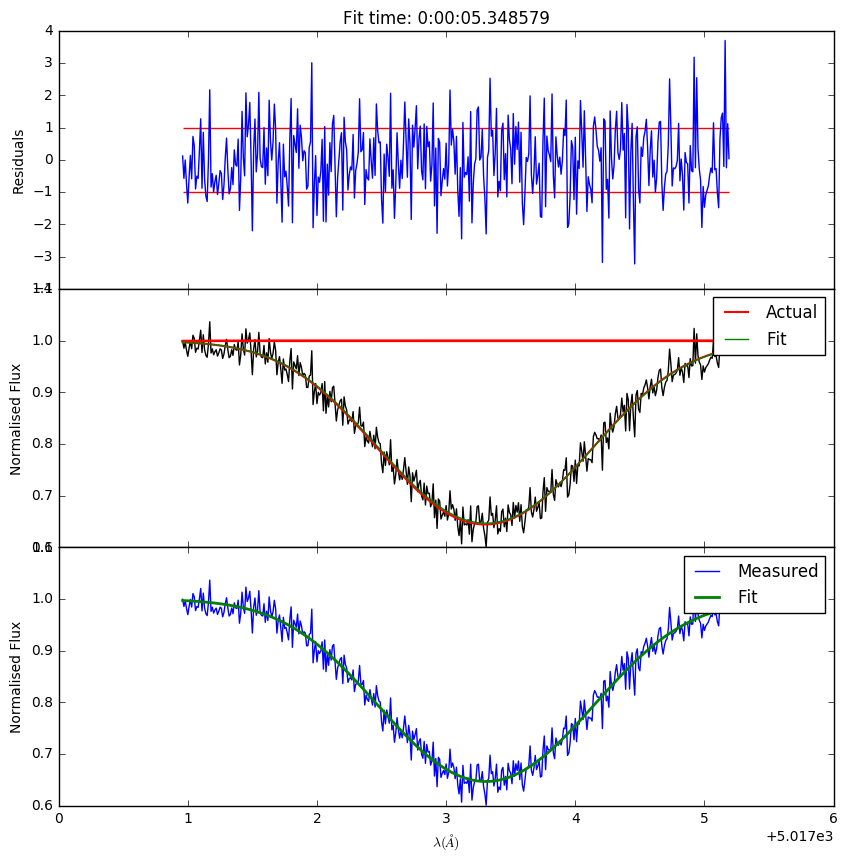

 [-----------------100%-----------------] 10000 of 10000 complete in 5.8 sec
Took: 0:00:05.799750  to finish.
n:  1
 [-----------------100%-----------------] 10000 of 10000 complete in 6.3 sec
Took: 0:00:06.335836  to finish.
-44.7983124652
-45.0066135306
0.995371767635


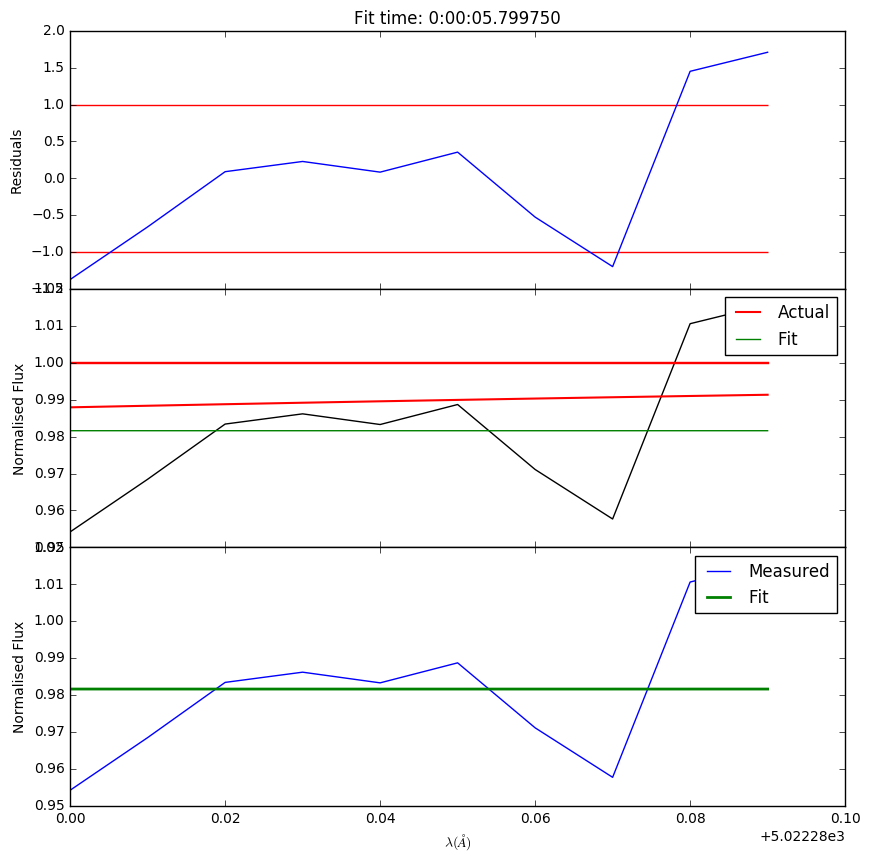

 [-----------------100%-----------------] 10000 of 10000 complete in 5.1 sec
Took: 0:00:05.117587  to finish.
n:  1
 [-----------------100%-----------------] 10000 of 10000 complete in 9.0 sec
Took: 0:00:09.047895  to finish.
-1215.07488595
-1229.38075666
0.988363352336


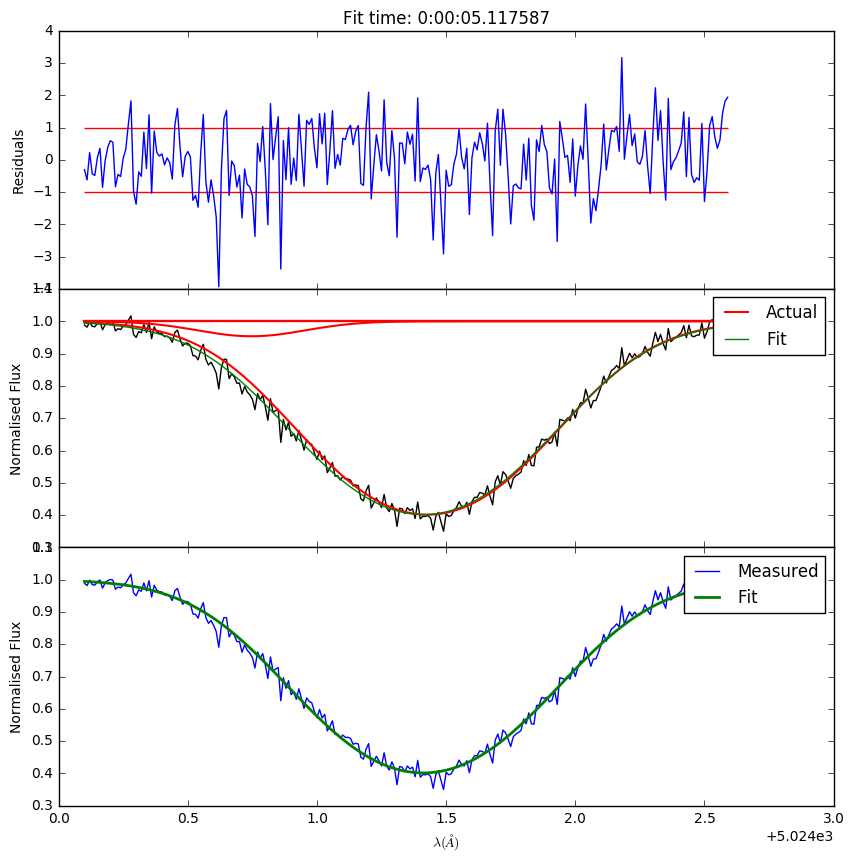

In [46]:
fits = []

for i in range(len(region_arrays)):
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    r = 0
    n = 1
    vpfit_2 = vpfits.VPfit()
    vpfit_2.fit(wavelengths, fluxes, n)

    while r < 0.95:

        print "n: ", n

        vpfit_1 = vpfit_2

        vpfit_2 = vpfits.VPfit()
        vpfit_2.fit(wavelengths, fluxes, n+1)

        print vpfit_1.mcmc.BPIC
        print vpfit_2.mcmc.BPIC

        print vpfit_1.mcmc.BPIC / vpfit_2.mcmc.BPIC

        r = vpfit_1.mcmc.BPIC / vpfit_2.mcmc.BPIC

        n += 1
    
    start = region_pixels[i][0]
    end = region_pixels[i][1]
    
    fits.append(vpfit_1)

    vpfit_1.plot(wavelengths, fluxes, clouds, n-1, start_pix=start, end_pix=end)

Finally, we can plot the detection regions and the fitted profiles over the entire spectrum.

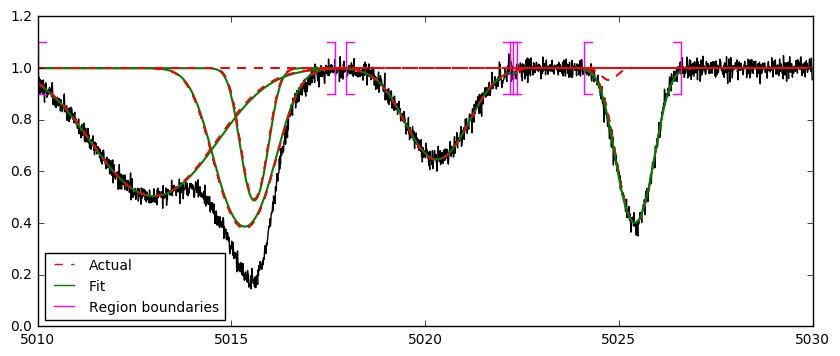

In [57]:
plt.plot(wavelength_array, flux_array, c='black')

for (start, end) in region_pixels:
    plot_bracket(wavelength_array[start], 'left')
    plot_bracket(wavelength_array[end], 'right')

for i in range(len(fits)):
    fit = fits[i]
    wavelengths = region_arrays[i][0]
    fluxes = region_arrays[i][1]
    
    for c in range(len(clouds)):
        plt.plot(wavelength_array, fit.Absorption(clouds.ix[c]['tau']), color="red", ls='--')
        
    for prof in fit.estimated_profiles:
        plt.plot(wavelengths, fit.Absorption(prof.value), color='green', lw=1.5)
        
plt.rcParams['figure.figsize'] = (10.0, 4.0)
handles = [mlines.Line2D([], [], color='red', label='Actual', ls='--'), mlines.Line2D([], [], color='green', label='Fit'),
          mlines.Line2D([], [], color='magenta', label='Region boundaries')]
plt.legend(handles=handles, prop={'size':10}, loc='best')
plt.show()